# Анализ программы лояльности для сети фитнес-центров 

### Шаг №1. Открыть файл с данными и изучить общую информацию** <a id="step1"></a>

---
Проведем импорт необходимых библиотек:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
gym = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
display(gym.shape)
display(gym.head())

(4000, 14)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Файл загружен: размер датафрейма 4000 строк и 14 столбцов, категориальные признаки отсутствуют - все признаки численные. Перейдем к следующему пункту, но перед этим приведем названия столбцов к нижнему регистру и проверим датафрейм на дубликаты.

In [4]:
gym.columns = gym.columns.str.lower()
display(gym.duplicated().sum())

0

Строки приведены к нижнему регистру, очевидных дубликатов нет - двигаемся дальше.

### Шаг №2. Провести исследовательский анализ данных (EDA) <a id="step2"></a>

---
**1. Посмотреть на датасет: есть ли в нем отсутствующие признаки, изучить средние значения и стандартные отклонения (пригодится метод describe())**<a id="step3"></a>

---
Воспользуемся методом describe() и info() для изучения датасета.

In [5]:
gym.info()
display(gym.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
near_location                        4000 non-null int64
partner                              4000 non-null int64
promo_friends                        4000 non-null int64
phone                                4000 non-null int64
contract_period                      4000 non-null int64
group_visits                         4000 non-null int64
age                                  4000 non-null int64
avg_additional_charges_total         4000 non-null float64
month_to_end_contract                4000 non-null float64
lifetime                             4000 non-null int64
avg_class_frequency_total            4000 non-null float64
avg_class_frequency_current_month    4000 non-null float64
churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


<div class="alert alert-block alert-info">
Сразу отметим что пропусков в данных нет и это здорово: не придется их обрабатывать. Теперь взглянем на средние значения и стандартные отклонения каждого столбца.
    
- gender - есть всего два значения (мужчина/женщина, 0/1, не буду делать предположения кто есть кто=)). Среднее значение (mean) около 0,5 и стандартное отклонение тоже 0,5. Логично, так как у нас или М или Ж. А вот медиана говорит нам о том, что все же больше представителей пола номер 1.
- near_location - также два значения (0 - расположен не близко, 1 - расположен рядом с домом). Среднее значение - 0,84, а медиана - 1. Клиенты, большей частью, живут рядом с клубом. На практике зачастую так и происходит - люди ищут зал поближе к дому. Величина отклонения равна 0,36 (к тому же первый квартиль также равен 1) подтверждает близость расположения клуба к домам клиентов.
- partner - (1 - есть промопартнер, 0 - нет). Среднее значение - 0,49, медиана - 0, отклонение - 0,5. Цифры говорят нам о том, что промопартнеров все таки меньше, но не намного (цифры сопоставимы).
- promo_friends - (1 - пришел с другом, 0 - без). Среднее значение - 0,31, медиана - 0, отклонение - 0,46. Пришедших в рамках акции "Приведи друга" меньше, чем самостоятельно пришедших. 
- phone - (1 - есть контакты, 0 - нет). Среднее значение - 0,9, медиана - 1, отклонение - 0,3 (первый квартиль тоже равен 1). На самом деле, все просто: для того чтобы записаться в клуб, на маникюр, даже в ресторан почти всегда требуется оставить контактный телефон. Поэтому удивление вызывает что не все это сделали. У подавляющего большинства контакты все же предоставлены.
- contract_period - (1, 3, 6 и 12 месяцев). Среднее значение - 4,7, медиана - 1, отклонение - 4,5 (третий квартиль - 6). Несмотря на довольно неплохое среднее значение, мы видим что половина абонементов - на 1 месяц (кстати, посмотрев уникальные значения этого столбца можно заметить что 3-х месячных абонементов вообще нет), и по четверти от общего приходится на 6-ти и 12-ти месячные.
- group_visits - (1 - посещает групповые занятия, 0 - нет). Среднее значение - 0,41, медиана - 0, отклонение - 0,49 (третий квартиль - 1). Больше половины клиентов не посещают групповые занятия, но четверть точно ходит на них.
- age - посмотрев на уникальные значения этого столбца можно увидеть что возраст клиентов колеблется от 18 до 41 года. Среднее значение - 29, медиана - 29, отклонение - 3. Первый столбец, в котором медиана и среднее значение практически равны друг друг. Возраст клиентов без разбросов и без перекосов. Может и хорошо, когда зал посещает определенная возрастная категория людей - ментально вы "на одном уровне, одной волне"
- avg_additional_charges_total - Среднее значение - 147, медиана - 136, отклонение - 96. Выручка от других услуг центра в среднем и по медиане недалеки друг от друга. Но размер отклонения говорит нам что все люди тратят по-разному: кто-то приходит только тренироваться, а кому-то надо и поесть до и после, сходить в солярий и прочее.
- month_to_end_contract - поскольку максимальный срок договора 12 месяцев, то и значения варьируются от 1 до 12. Среднее значение - 4,3, медиана - 1, отклонение - 4,2. Величина явно связана с длительностью договора и поэтому представляется логичным, что у 50% клиентов всего месяц до истечения договора
- lifetime - Среднее значение - 3.7, медиана - 3, отклонение - 3.7. Значениястолбца варьируются от 0 до 31 месяца, но таких долгожителей единицы. В среднем клиенты в первый раз пришли в зал 3-4 месяца назад.
- avg_class_frequency_total - Среднее значение - 1,88, медиана - 1,83, отклонение - 0,97. С посещаемостью у наших клиентов прямо беда - в среднем меньше 2 раз в неделю посещают зал, хотя третий квартиль 2,5 слегка обнадеживает - хотя бычетверть клиентов тренируется регулярно.
- avg_class_frequency_current_month - Среднее значение - 1,77, медиана - 1,72, отклонение - 1,05. В целом ситуация в этом месяце похожа на общую, но даже немного хуже - посещаемость поменьше, а отклонение побольше.
- churn - (1 - клиент ушел, 0 - клиент остался). Среднее значение - 0,26, медиана - 0, отклонение - 0,44 (третий квартиль 1). Порядка четверти наших клиентов ушли. Нам предстоит разобраться можно ли как то определить какие группы клиентов (на основании предыдущих признаков), которые более склонны к уходу.

<div/>

**2. Посмотреть на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался (воспользоваться методом groupby())**<a id="step4"></a>

---
Воспользуемся методом groupby, аргументом которому передадим столбец "churn", и методом mean() для определения среднего.

In [6]:
display(gym.groupby('churn').mean())

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Мы сгруппировали наш датафрейм по столбцу 'churn' и вывели средние показатели по признакам. Сравним их и попробуем сделать первые предположения:

- gender - средние показатели ушедших и оставшихся примерно равен - видимо пол не сильно влияет на отток клиентов.
- near_location - у тех кто остался этот признак немного больше, чем у тех кто ушел (0,87 против 0,77) - то есть проживание рядом с клубом имеет роль
- partner - 0,53 у оставшихся против 0,36 ушедших - скидка от партнера вещь хорошая, даже мотивирующая на занятия спортом=)
- promo_friends - 0,35/0,18 - разница почти в 2 раза - то есть те кто пришел как друг имеют свойство остаться чаще, чем те кто пришел сам. Оно и логично - вдвоем ходить веселее.
- phone - средние значения почти аналогичны, влияние этого признака, если и есть, то незаметно
- contract_period - 5,75/1,73 - а вот длительность текущего абонемента оказывает сильное влияние - у тех кто остался в среднем заключен контракт на полгода, а у ушедших очень много месячных контрактов
- group_visits - 0,46/0,27 - те, кто ходит на групповые занятия реже бросают зал - новые/старые знакомые, общение, коллектив - все это удерживает
- age - 30/27 - чем старше человек, тем лучше он продумывает свои действия и если уж решил заниматься, то грех бросать
- avg_additional_charges_total - 158/115 - суммарная выручка от других услуг центра также выше у тех кто остался
- month_to_end_contract - 5,28/1,66 - все в точности как и с длительностью контракта - у кого оплачено тот не бросает
- lifetime 4,7/1 - и опять - сбегают те, кто в момент замотивировался, взял месячный абонемент и ... кончилась мотивация
- avg_class_frequency_total - 2,02/1,48 - чаще ходят те, кто не планирует уходить
- avg_class_frequency_current_month - 2,02/1,05 - как видим для тех кто остался месячный показатель совпадает с общим, а для тех кто ушел - он становится еще меньше

Предположения:
1. Пол и наличие контакта не влияют на посещение зала
2. Наличие скидок и промо удерживает людей в зале
3. Собственно, удерживает и наличие друзей или групповые тренировки
4. Месячные абонементы как приговор - купил такой абонемент и ушел в закат
5. Частота посещения влияет на то, останется ли клиент и она стабильна на всем периоде для тех, кто не планирует "сбегать".

**3. Построить столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)**<a id="step5"></a>

---
Разделим наш датафрейм на 2 части методом query - для тех кто с нами gym0 и для тех кто бросил gym1 и уберем столбец 'churn' из этих таблиц,чтобы остались только признаки и заодно посмотрим сколько людей в каждом датафрейме.

In [7]:
gym0 = gym.query('churn == "0"').reset_index(drop=True).drop('churn', axis = 1)
gym1 = gym.query('churn == "1"').reset_index(drop=True).drop('churn', axis = 1)
display(gym0.shape, gym1.shape)

(2939, 13)

(1061, 13)

Мы получили что порядка 25% посетителей с прошлого месяца ушли (1061 человек из 4000). Теперь построим столбчатые гистограммы и распределения. Для этого применим distplot() библиотеки seaborn и сделаем это в цикле чтобы не строить графики отдельно для каждого признака. Для наглядности будем строить на каждом графике каждый признак для 2 групп - gym0 (оставшиеся) и gym1 (ушедшие).

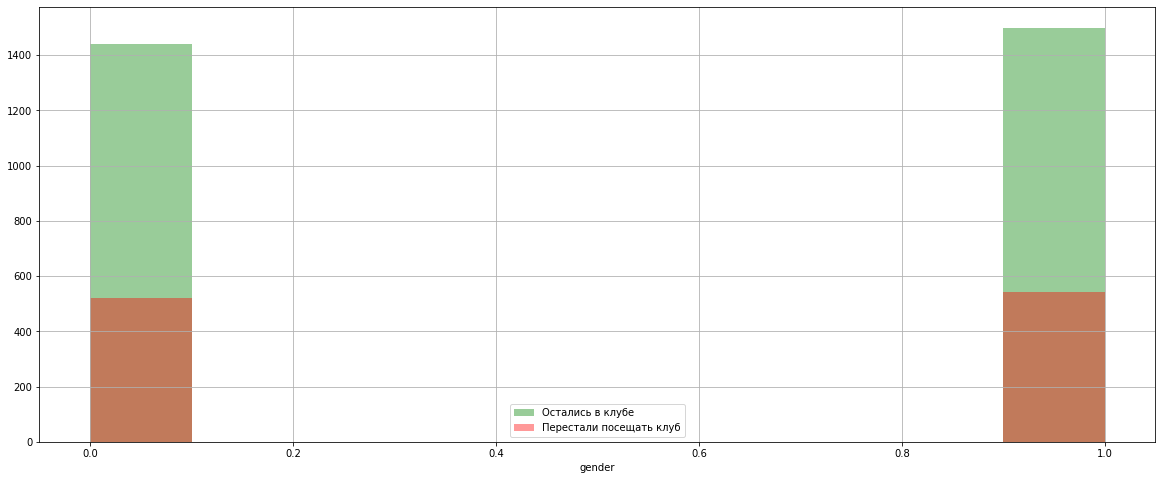

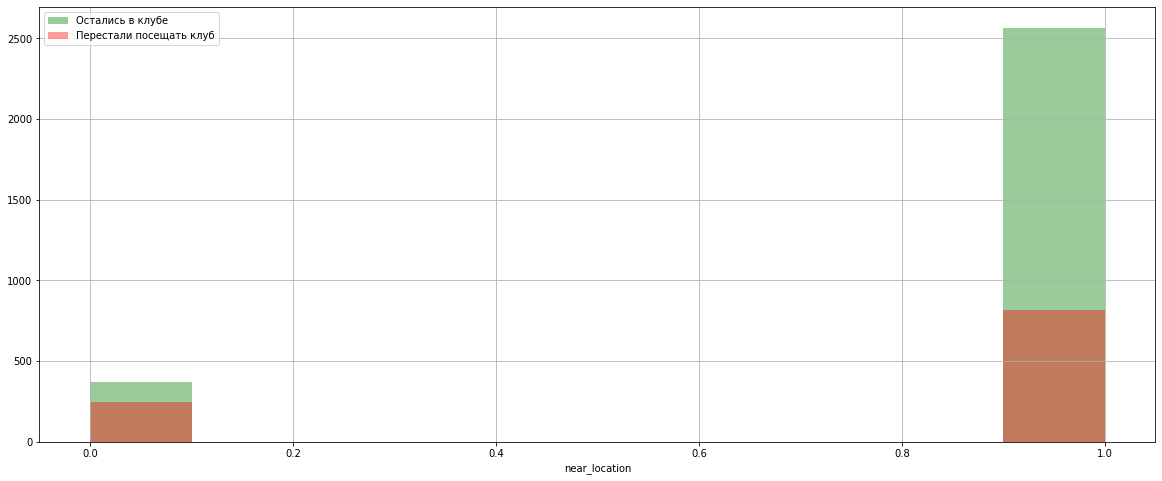

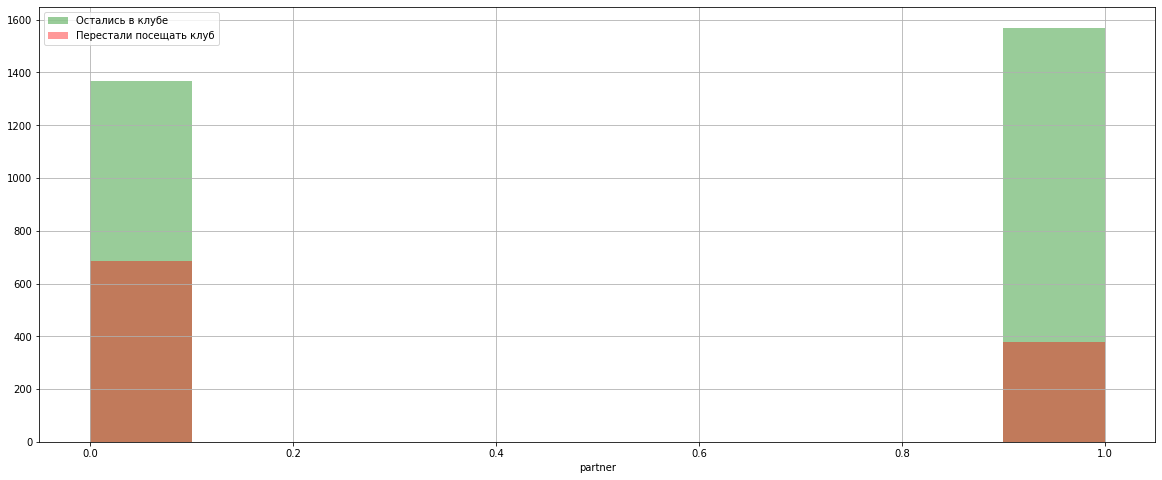

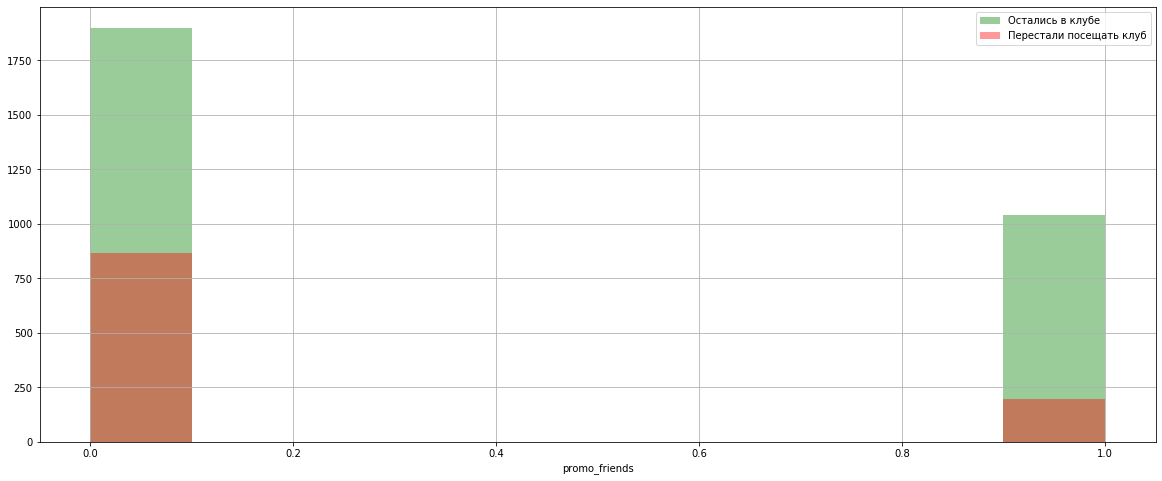

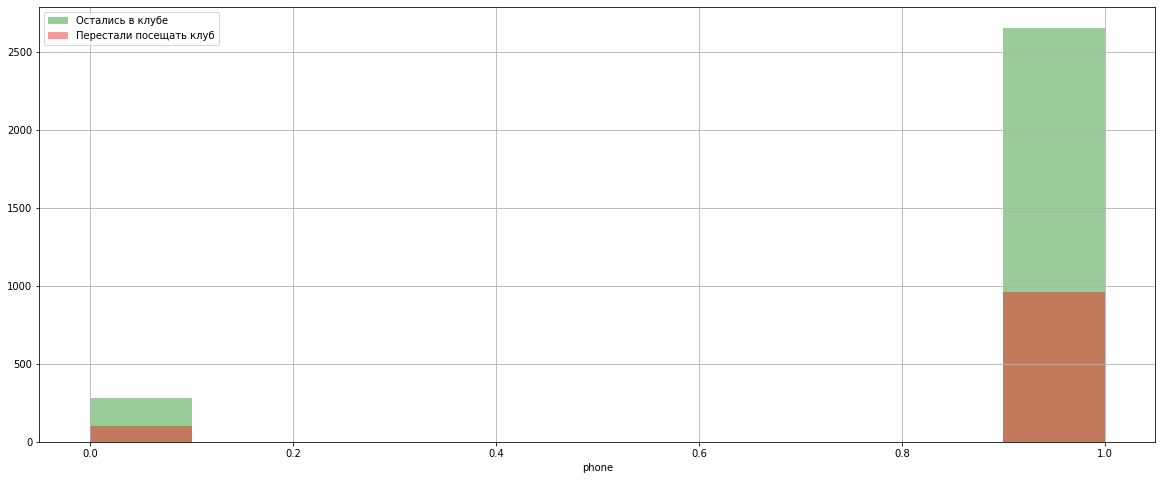

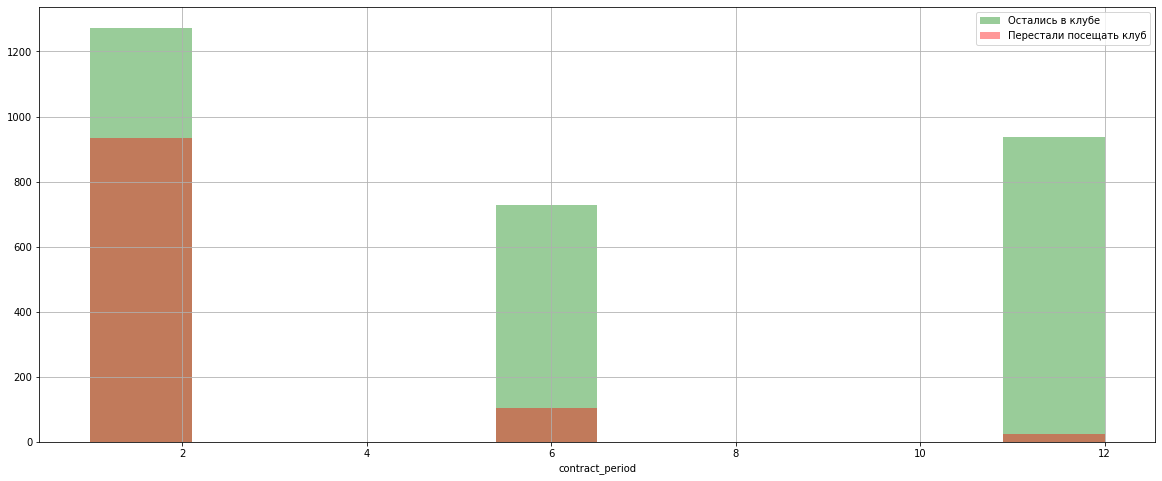

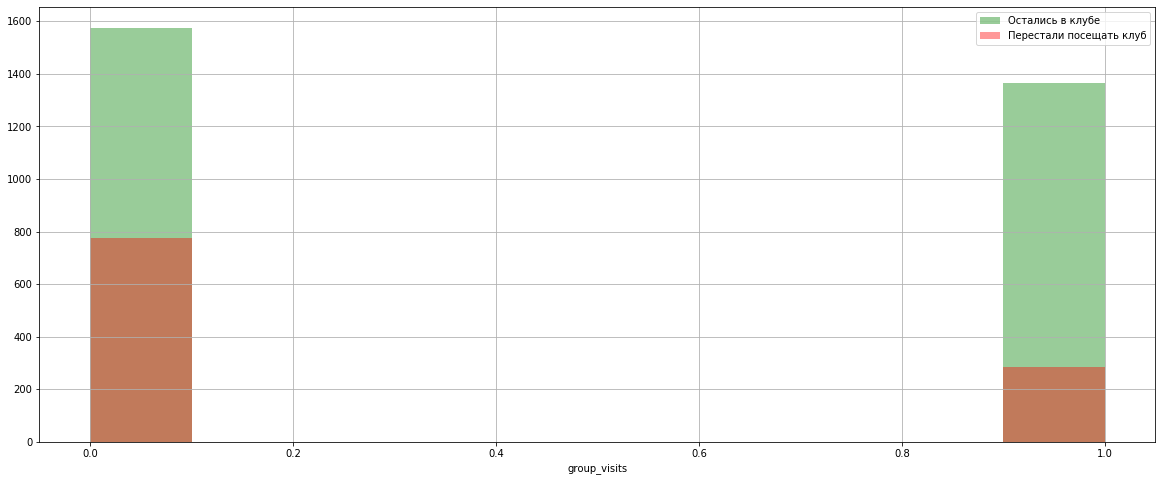

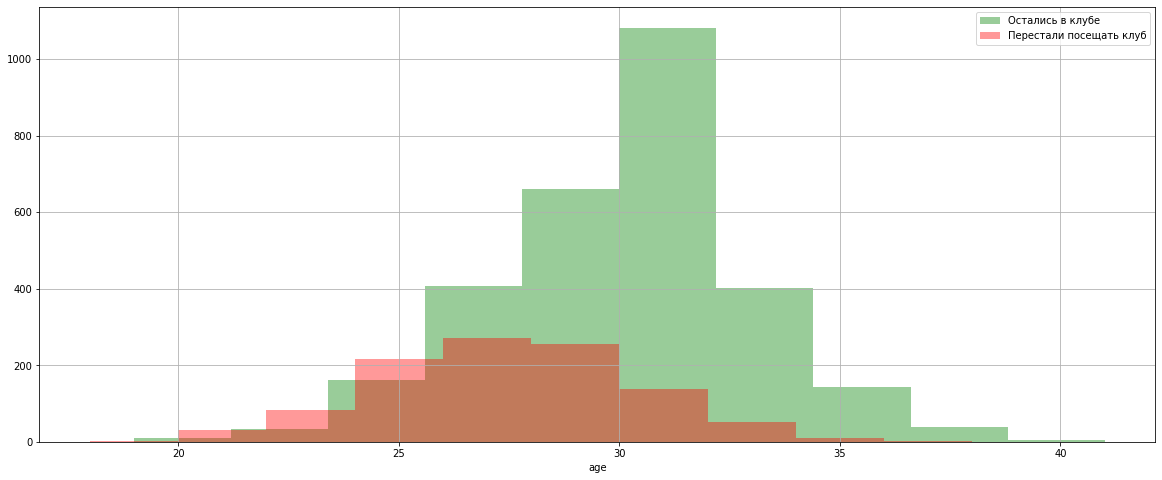

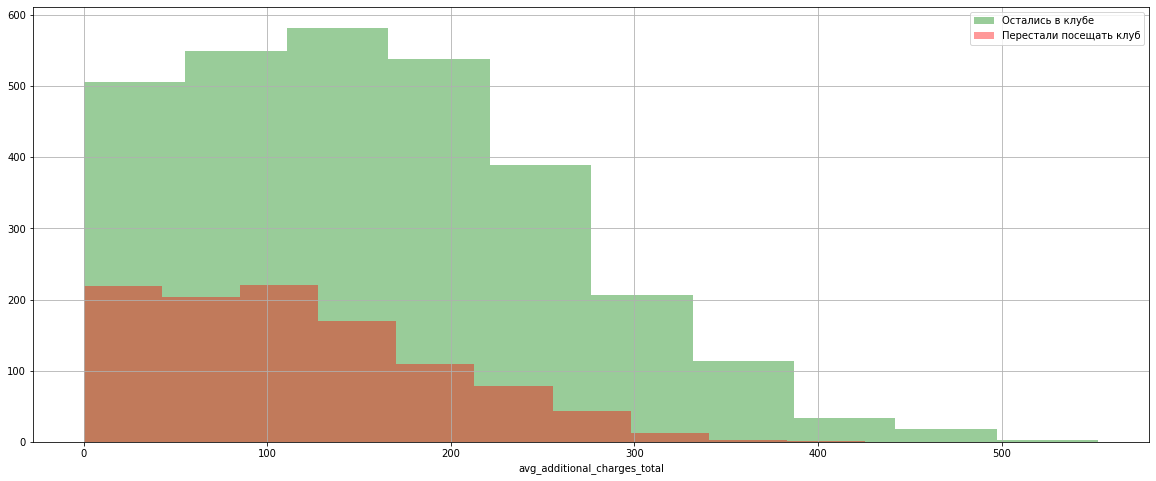

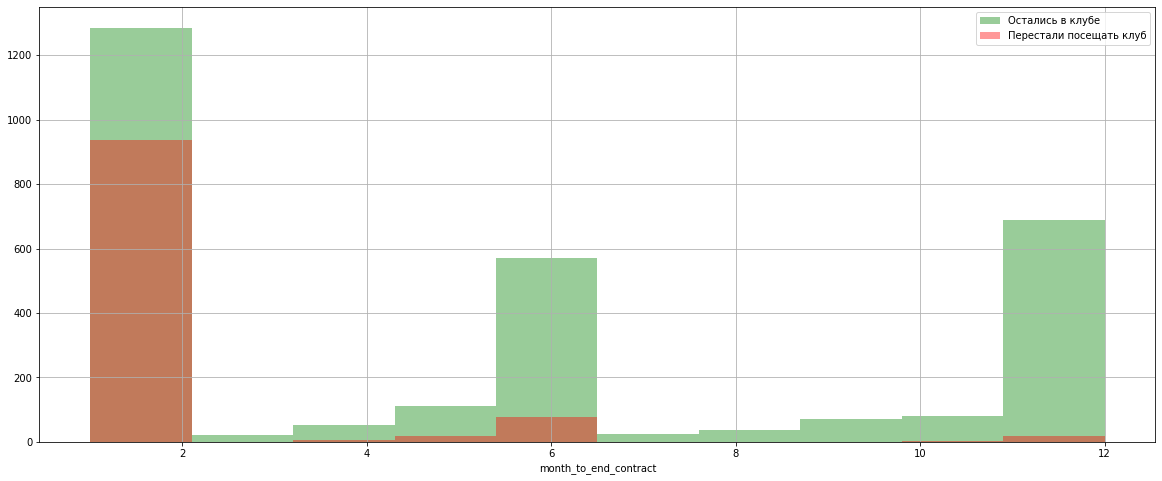

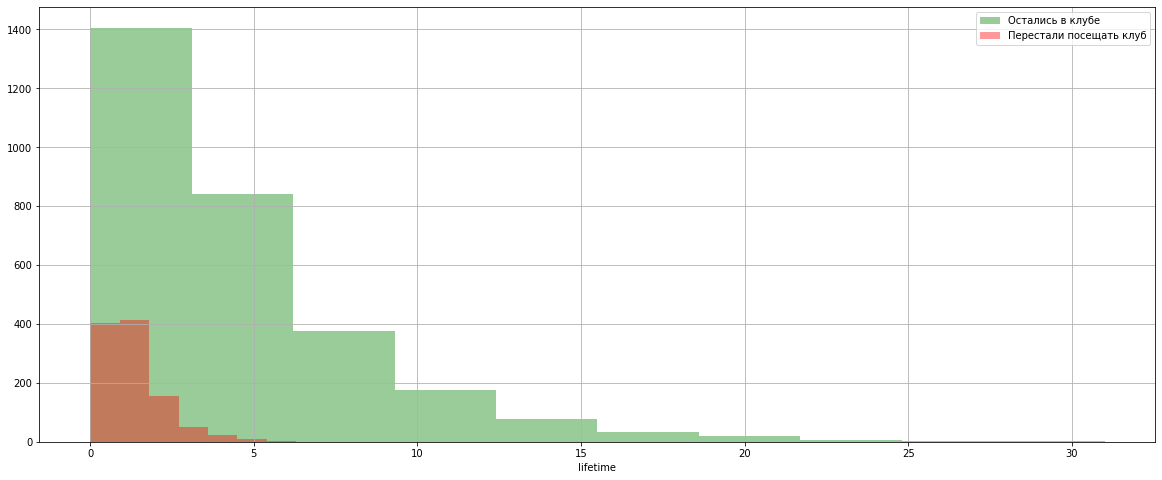

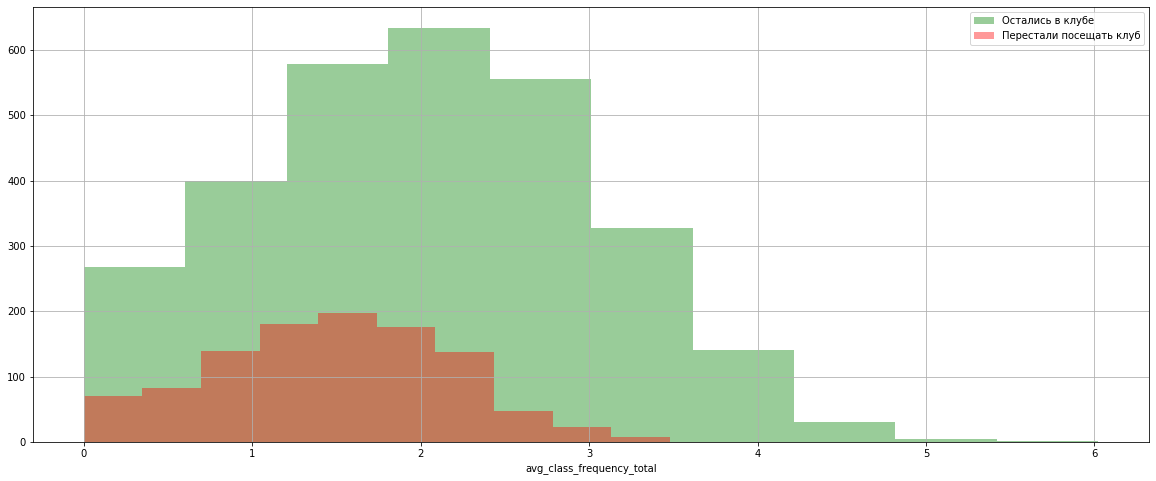

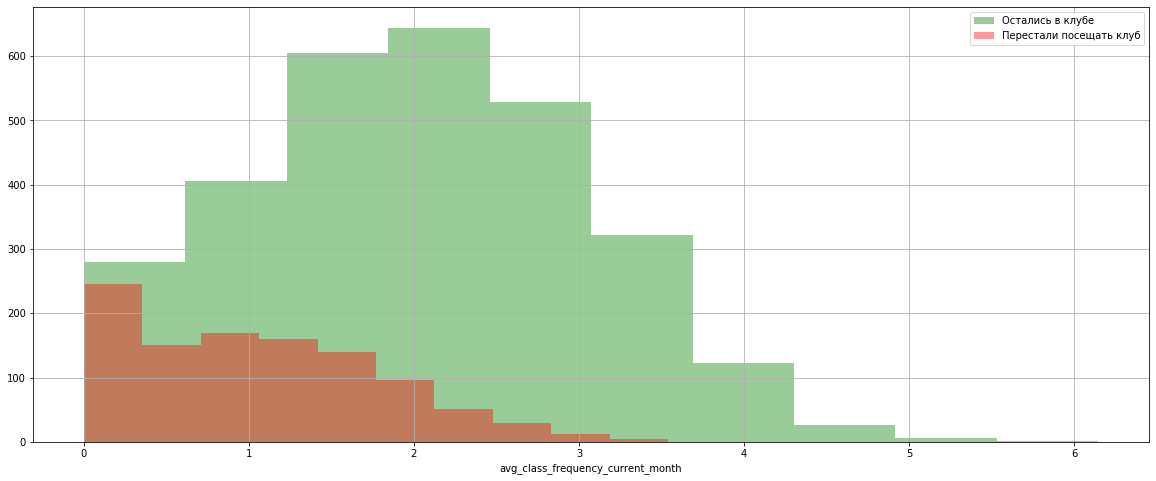

In [8]:
for feature in gym0.columns:
    fig = plt.gcf()
    fig.set_size_inches(20, 8)
    sns.distplot(gym0[feature], bins = 10, color="g", label='Остались в клубе', norm_hist=False, kde=False)
    sns.distplot(gym1[feature], bins = 10, color="r", label='Перестали посещать клуб', norm_hist=False, kde=False)
    plt.grid()
    plt.legend()
    plt.show()

Графики подтверждают предположения из прошлого пункта. Опишем то, что мы видим на графиках:

- gender - средние показатели ушедших и оставшихся примерно равен - видимо пол не сильно влияет на отток клиентов
- near_location - проживание рядом с клубом имеет роль, оставшиеся живут поближе чем ушедшие
- partner - наличие промопартнеров также удерживает клиентов
- promo_friends - те кто пришел как друг имеют свойство остаться чаще, чем те кто пришел сам
- phone - чуть лучше остаются те, кто оставил контактные данные
- contract_period - длительность текущего абонемента оказывает сильное влияние - у тех кто остался в среднем заключен контракт на большее время
- group_visits - те, кто ходит на групповые занятия реже бросают зал - новые/старые знакомые, общение, коллектив - все это удерживает
- age - чем старше человек, тем он более осознанно подходит к тренировкам
- avg_additional_charges_total - суммарная выручка от других услуг центра также выше у тех кто остался
- month_to_end_contract - все в точности как и с длительностью контракта - у кого оплачено тот не бросает
- lifetime - сбегают те, кто в момент замотивировался, взял месячный абонемент и ... кончилась мотивация
- avg_class_frequency_total - чаще ходят тренироваться те, кто не планирует уходить
- avg_class_frequency_current_month - как видим для тех кто остался месячный показатель совпадает с общим, а для тех кто ушел - он становится еще меньше

**4. Построить матрицу корреляций и отобразить её**<a id="step6"></a>

---
На этом этапе уже можно посмотреть:
- какие признаки наиболее сильно коррелируют с целевой переменной
- какие признаки сильно коррелируют между собой (Для линейных моделей взаимная корреляция нежелательна)

Расчёт матрицы корреляций методом датафреймов corr() занимает одну строчку кода:

In [9]:
cm = gym.corr()
display(cm)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
near_location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


Теперь в переменной cm хранится матрица корреляций. Чтобы представить её визуально, воспользуемся методом heatmap() библиотеки seaborn:

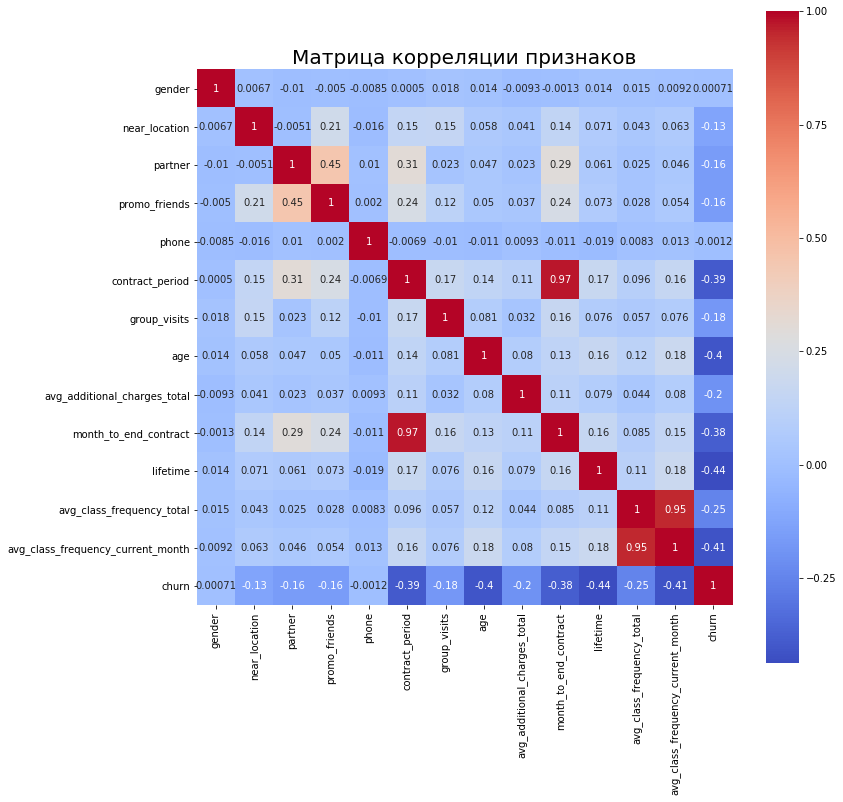

In [10]:
fig = plt.gcf()
fig.set_size_inches(12, 12)
sns.heatmap(cm, annot = True, square=True, cmap= 'coolwarm', fmt='.2g')
plt.title("Матрица корреляции признаков", fontsize =20)
plt.show()

Какие выводы можно сделать по нашей тепловой карте:

Какие признаки наиболее сильно коррелируют с целевой переменной:

 - пол и оставленный номер телефона никак не коррелируют с целевой переменной (значение около 0)
 - самая сильная связь с целевой переменной у признаков, связанных с посещением зала - частота тренировок, срок действия абонемента, время с момента первого посещения и возраст
 
Какие признаки сильно коррелируют между собой:

 - средняя частота посещений в неделю за все время с начала действия абонемента и средняя частота посещений в неделю за предыдущий месяц имеют коэффициент корреляции 0,95! - то есть эти 2 признака очень коррелируют между собой
 - срок до окончания текущего действующего абонемента (в месяцах) и длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год) - 0,97
 - 'Partner' и 'Promo_friends' - 0,45 - связь не очень сильная, но она есть
 
Таким образом, некоторые наши предположения из предыдущих пунктов подтвердились с помощью матрицы корреляции.

### Шаг №3. Построить модель прогнозирования оттока пользователей <a id="step7"></a>

---
**1. Разбить данные на обучающую и валидационную выборку функцией train_test_split()**<a id="step8"></a>

---
Разделим наши данные на признаки (матрица Х) и целевую переменную (у).

In [11]:
X = gym.drop('churn', axis = 1)
y = gym['churn']

Теперь разделяем модель на обучающую и валидационную выборки, затем обучим и применим «стандартизатор» на обучающей выборке. Как делить выборку? Принципиально существует два подхода: случайно и с учётом времени.

Случайное разбиение применяется, когда мы прогнозируем НЕ временные ряды, т. е. когда мы пренебрегаем влиянием соседних наблюдений друг на друга. Это как раз подходит под нашу задачу.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)

Применяем стандартизацию к матрице признаков для тестовой выборки

In [13]:
X_test_st = scaler.transform(X_test)

Выборку разделили, стандартизировали, самое время обучить нашу модель.

**2. Обучить модель на train-выборке двумя способами: логистической регрессией, случайным лесом**<a id="step9"></a>

---
Для выполнения этого пункта нам потребуется две модели: LogisticRegression() и RandomForestClassifier()(так как наши данные стандартизированны). Зададим алгоритм для этих моделей, обучим их, а затем воспользуемся обученными моделями, чтобы сделать прогнозы.

In [14]:
lr_model = LogisticRegression(random_state = 0)
lr_model.fit(X_train_st, y_train)
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

In [15]:
rf_model = RandomForestClassifier(random_state = 0)
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

**3. Оценить метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравнить по ним модели. Какая модель показала себя лучше на основании метрик?**<a id="step10"></a>

---
Создадим функцию display_all_metrics для оценки требуемых метрик и сравним их для логистической регрессии и случайного леса. Добавим для сравнения также метрики f1 и rocauc, ведь rocauc содержит в себе наибольшее количество информации о качестве модели.

In [16]:
def display_all_metrics(y_true, y_pred, y_proba, title = 'Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [17]:
display_all_metrics(y_test, lr_predictions, lr_probabilities , title='Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
	Accuracy: 0.94
	Precision: 0.90
	Recall: 0.85
	F1: 0.87
	ROC_AUC: 0.98


In [18]:
display_all_metrics(y_test, rf_predictions, rf_probabilities, title = 'Метрики для модели случайного леса:')

Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.89
	Recall: 0.79
	F1: 0.83
	ROC_AUC: 0.96


<div class="alert alert-block alert-info">
Рассмотрим что же это за метрики:
    
- Accuracy: это доля верно угаданных ответов из всех прогнозов. Чем ближе значение accuracy к 100%, тем лучше. На вход функция принимает верные и спрогнозированные значения классов на валидационной выборке. Accuracy работает не всегда, а только при условии баланса классов — когда объектов каждого класса примерно поровну, 50% : 50%. И вот почему. Если классы не сбалансированные: всего 1% класса "1" среди выборки, а оставшиеся объекты относятся к классу "0". Тогда безо всякого алгоритма можно придерживаться железной стратегии — всегда прогнозировать класс "0". Красота! Метрика accuracy — целых 99%! И не нужно никакого машинного обучения. 
- Precision: говорит, какая доля прогнозов относительно "1" класса верна. То есть смотрим долю правильных ответов только среди целевого класса. В бизнесе метрика precision нужна, если каждое срабатывание (англ. alert) модели — факт отнесения к классу "1" — стоит ресурсов. А мы не хотим, чтобы модель часто «срабатывала попусту». Например, когда мы принимаем решение, выдавать клиенту кредит или нет, ситуация невозврата более неприятна, чем невыдача. Метрика принимает значения от 0 до 1. Чем ближе к единице, тем лучше.
- Recall: нацелена на минимизацию противоположных рисков — recall показывает, сколько реальных объектов "1" класса мы смогли обнаружить с помощью модели. Эта метрика полезна при диагностике заболеваний: лучше отправить пациента на повторное обследование и узнать, что тревога была ложной, чем прозевать настоящий диагноз. Метрика принимает значения от 0 до 1. Чем ближе к единице, тем лучше.
- F1: Так как precision и recall направлены на избежание противоположных рисков, нужна сводная метрика, учитывающая баланс между метриками. Это F1-score. Функция также возвращает одно число от 0 до 1. Чем ближе к единице, тем лучше.
- ROC_AUC: Вышеизложенные метрики работают на основе итоговых меток для прогноза: "0" или "1". Можно предсказывать не только ответ для каждого наблюдения – "0" или "1" – но и вероятность того, что наблюдение принадлежит к классу "0" или "1". Например, оценивая фотографии разных людей, модель может определять, мужчина это или женщина. А может и так: «с вероятностью 90% эта фотография мужчины». Вот почему для оценки качества модели применяют метрику roc_auc, или площадь под кривой ошибок — AUC-ROC (от англ. Area Under Curve, «площадь под кривой», Receiver Operating Characteristic, «рабочая характеристика приёмника»).
    
Логика метрики: «Если отсортировать объекты по вероятности, которую спрогнозировала модель, насколько хорошо будут выделяться реальные классы объектов?» Иначе говоря, будет ли такое, что на одном конце в основном скопились объекты класса "0", а на другом — класса "1". Причём, если вероятности совсем плохо сортируют наши объекты, каким бы мы ни выбрали порог, остальные метрики лучше не станут. А когда объекты отсортированы неплохо, можно считать, что в целом модель ведёт себя адекватно, а порог настраивать уже отдельно.
    
В результате мы получили что логистическая регрессия по всем метрикам показывает себя лучше случайного леса.
<div/>


### Шаг №4.  Сделать кластеризацию пользователей<a id="step11"></a>

---
**1. Стандартизировать данные.**<a id="step12"></a>

---
Стандартизация приведёт значения признаков к виду стандартного нормального распределения: значения будут центрированы относительно 0, а средний разброс данных составит 1. Стандартизируем данные. На выходе получим преобразованные таблицы объект-признак для обучающего и валидационного набора. И уже их будем применять для обучения и прогнозирования.

In [19]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

**2. Построить матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисовать дендрограмму. Внимание: отрисовка дендрограммы может занять время! На основании полученного графика предположить, какое количество кластеров можно выделить.**<a id="step13"></a>

---
После выполнения стандартизации передадим получившуюся стандартизированную таблицу в качестве параметра функции linkage(). Чтобы диаграмма получилась показательной, лучше передать параметру method значение 'ward':

In [20]:
linked = linkage(X_sc, method = 'ward')

В переменной linked сохранена таблица «связок» между объектами. Её можно визуализировать как дендрограмму.

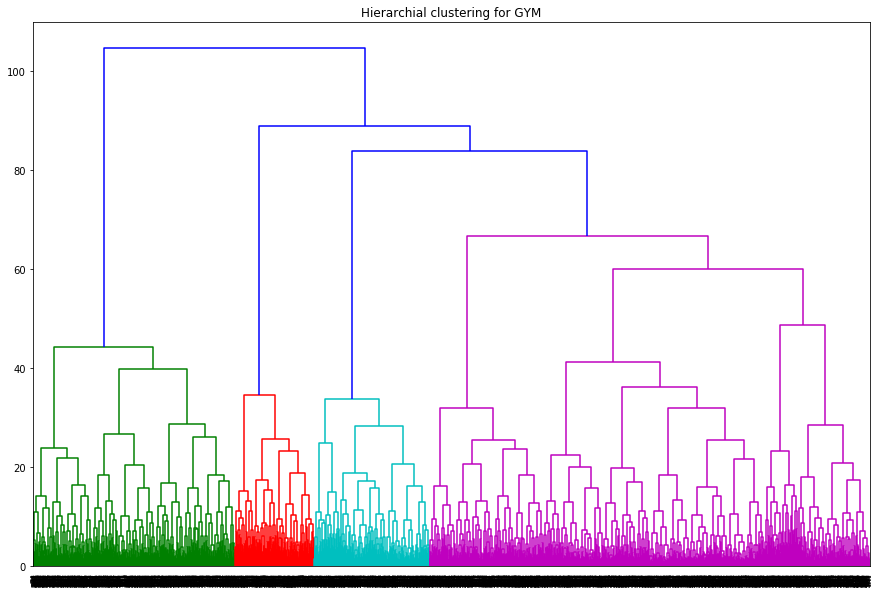

In [21]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show()

Предложенное оптимальное число кластеров 4 — четыре разных цвета на графике. Сложность агломеративной кластеризации заключается не в устройстве самого алгоритма, а в вычислениях, которые машина совершает для построения дендрограммы. Расчёты попарных расстояний могут занять очень много времени. Потому при решении задачи кластеризации полезно строить дендрограмму на случайной подвыборке, а после оценки оптимального числа кластеров запустить более быстрый алгоритм K-Means.

**3. Обучить модель кластеризации на основании алгоритма K-Means и спрогнозировать кластеры клиентов. Договоримся за число кластеров принять n=5, чтобы результаты можно было сравнивать с результатами остальных студентов. Однако, конечно, в жизни никто не скажет вам правильный ответ, и решение остаётся за вами (на основании изучения графика из предыдущего пункта).**<a id="step14"></a>

---
Задаём модель k_means с числом кластеров 5. Затем прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4). Сохраняем метки кластера в поле нашего датасета в столбце 'gym_cluster'. Посчитаем также метрику силуэта, которая показывает насколько объект своего кластера похож на свой кластер больше, чем на чужой. На вход передаём нормализованную или стандартизованную матрицу признаков и метки, которые спрогнозировал алгоритм кластеризации, в виде списка.
Значение метрики силуэта принимает значения от -1 до 1. Чем ближе к 1, тем качественнее кластеризация.

In [22]:
km = KMeans(n_clusters = 5, random_state = 0)
labels = km.fit_predict(X_sc)
gym['gym_cluster'] = labels
print('Silhouette_score: {:.2f}'.format(silhouette_score(X_sc, labels)))


Silhouette_score: 0.14


Значение метрики не очень высоко. Но это ожидаемо: очень редко можно найти процесс, в котором объекты имеют явную структуру и ярко выраженное разделение.

**4. Посмотреть на средние значения признаков для кластеров. Можно ли сразу что-то заметить?**<a id="step15"></a>

---
Методом groupby сгруппируем наш датафрейм по кластерам и выведем методом mean средние значения, а затем взглянем на таблицу.

In [23]:
display(gym.groupby('gym_cluster').mean())

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gym_cluster,,,,,,,,,,,,,,
0,0.502473,0.959446,0.783383,0.574679,1.000000,10.884273,0.543027,29.980218,160.706969,9.950544,4.738872,1.983305,1.976225,0.027695
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.560335,0.976105,0.356033,0.229391,0.998805,2.665472,0.473118,30.127838,161.724258,2.455197,4.896057,2.851531,2.849473,0.068100


<div class="alert alert-block alert-info">
И снова пройдемся по признакам в поисках особенностей:

- gender - средние показатели по кластерам близки друг другу
- near_location - есть 2 граничных кластера (номер 3 - рядом с домом, кластер 2 - далеко от дома) и 3 кластера близких к рядом с домом
- partner - кластер 0 выделяется - его среднее значение почти вдвое больше остальных
- promo_friends - кластер 0 также выделяется
- phone - все кто не оставил данные попали в кластер номер 1
- contract_period - длительность текущего абонемента - в кластере 0 те, у кого в среднем абонемент намного больше, в кластере 2,3,4 - клиенты с коротким сроком абонемента
- group_visits - в кластере 0 и 4 средние значения выше остальных
- age - кластер 0 и 4 в среднем возраст 30 лет, кластер 1 - 29 лет, 2 и 3 - 28 лет
- avg_additional_charges_total - суммарная выручка в среднем выше от кластеров 0 и 4
- month_to_end_contract - распределение совпадает с длительностью текущего контракта, кластер 0 в лидерах
- lifetime - в среднем чаще ходят кластера 4 и 0, чуть хуже 1, и хуже всех - 2 и 3
- avg_class_frequency_total - чаще ходят тренироваться клиенты из кластера 4, хуже всех - из кластера 3
- avg_class_frequency_current_month - как видим для тех кто остался месячный показатель совпадает с общим, а для тех кто ушел - он становится еще меньше. Кластер 4 самый постоянный.

churn - сделаем предварительные выводы по целевой переменной - кластер 0 и 4 - клиенты, которые занимаются и не планируют бросать это делать, а кластеры 2 и 3 - наполовину состоит из месячников, порыва на занятия у них хватает на короткий срок. Кластер 1 - нечто среднее для всего датасета - порядка 25 процентов оттока как и в среднем по всей таблице.


    

<div/>

**5. Построить распределения признаков для кластеров. Можно ли что-то заметить по ним?**<a id="step16"></a>

---
Построим распределения методом distpltot() . Сделаем это в цикле, и отобразим распределение признака для каждого кластера на одном графике - для наглядности и возможности сравнения между собой. А перед этим разделим наш датафрейм по кластерам.

In [24]:
gym_cluster0 = gym.query('gym_cluster == "0"').reset_index(drop=True)
gym_cluster1 = gym.query('gym_cluster == "1"').reset_index(drop=True)
gym_cluster2 = gym.query('gym_cluster == "2"').reset_index(drop=True)
gym_cluster3 = gym.query('gym_cluster == "3"').reset_index(drop=True)
gym_cluster4 = gym.query('gym_cluster == "4"').reset_index(drop=True)

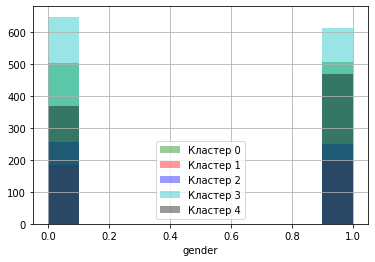

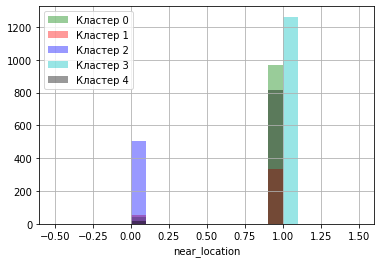

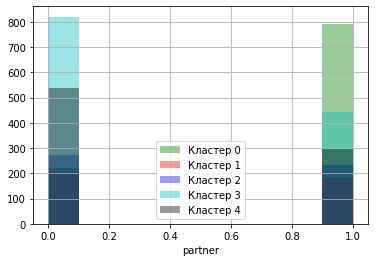

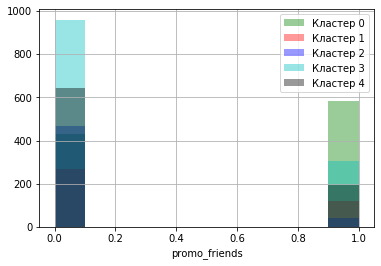

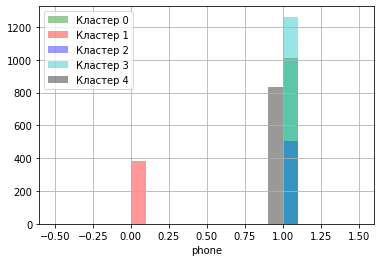

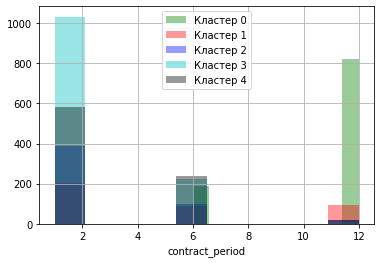

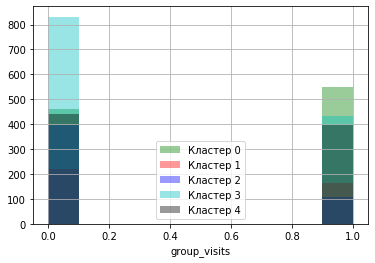

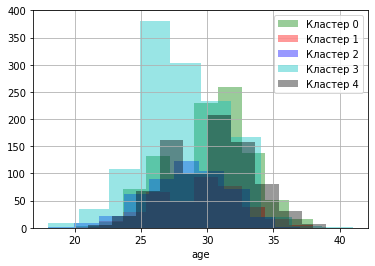

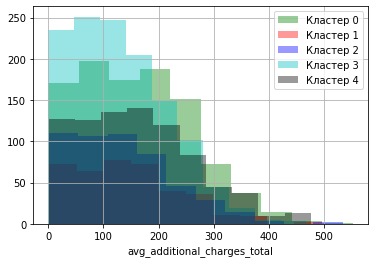

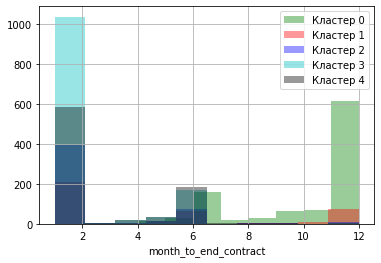

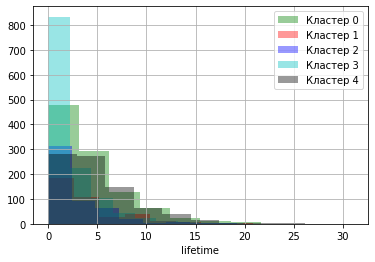

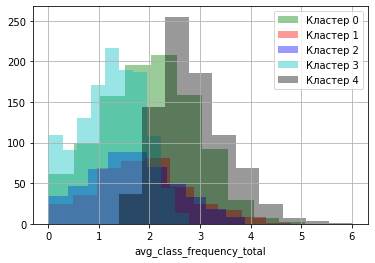

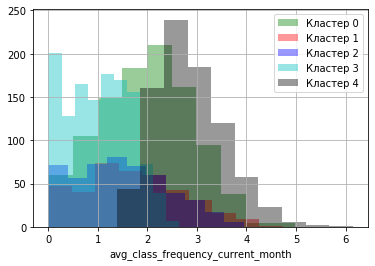

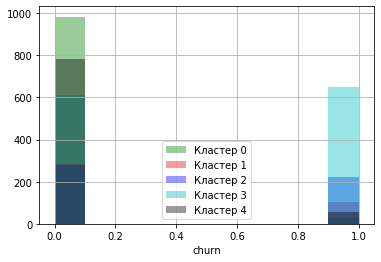

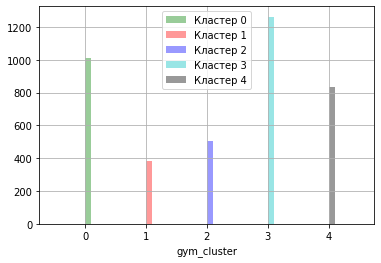

In [25]:
for feature in gym_cluster0.columns:
    sns.distplot(gym_cluster0[feature], bins = 10, color="g", label='Кластер 0', norm_hist=False, kde=False)
    sns.distplot(gym_cluster1[feature], bins = 10, color="r", label='Кластер 1', norm_hist=False, kde=False)
    sns.distplot(gym_cluster2[feature], bins = 10, color="b", label='Кластер 2', norm_hist=False, kde=False)
    sns.distplot(gym_cluster3[feature], bins = 10, color="c", label='Кластер 3', norm_hist=False, kde=False)
    sns.distplot(gym_cluster4[feature], bins = 10, color="k", label='Кластер 4', norm_hist=False, kde=False)
    plt.grid()
    plt.legend()
    plt.show()
  
    

Также построим графики методом boxplot() для большей наглядности.

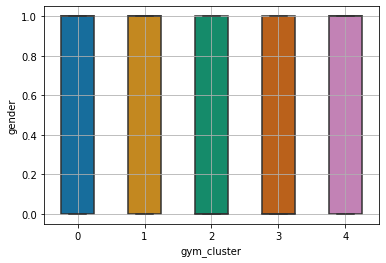

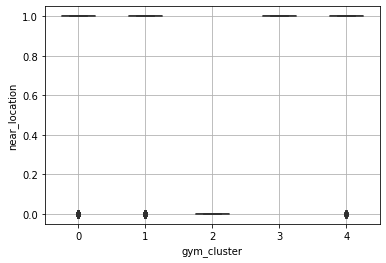

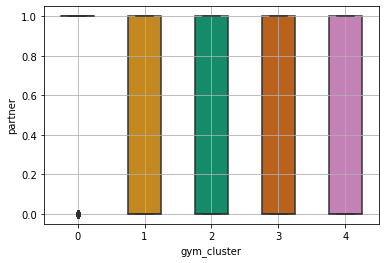

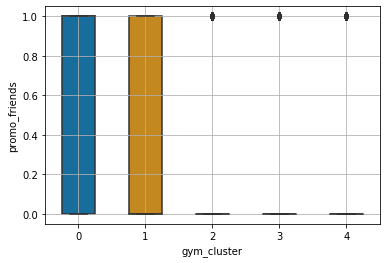

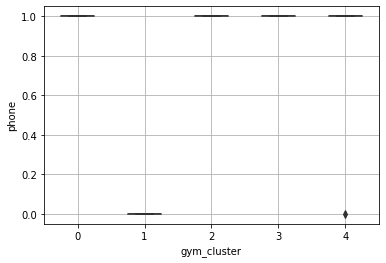

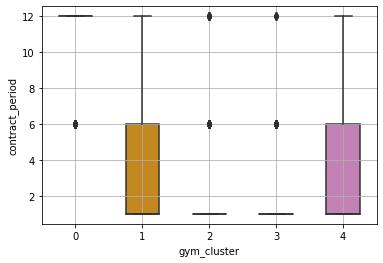

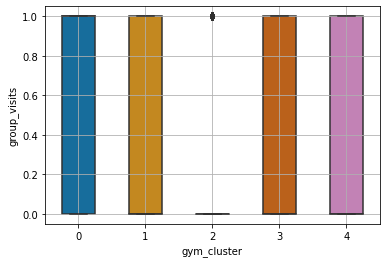

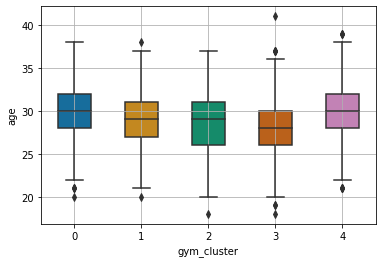

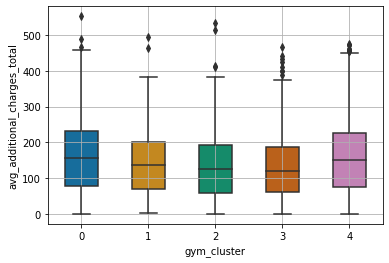

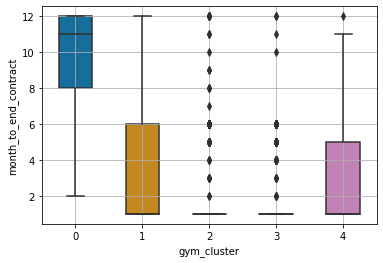

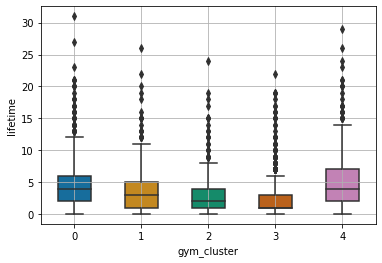

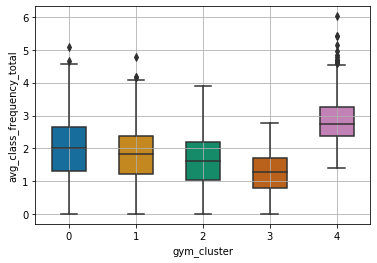

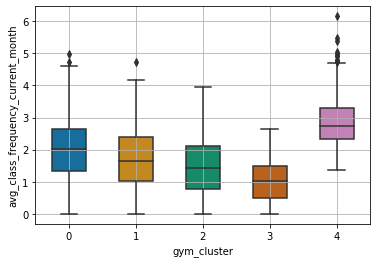

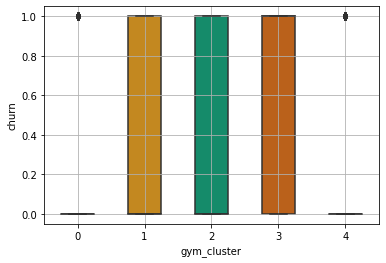

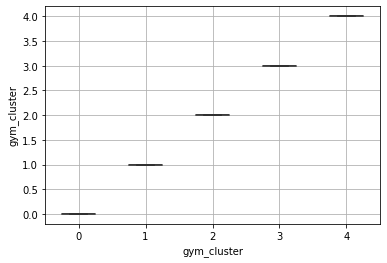

In [26]:
for feature in gym:
    sns.boxplot(y=feature, x='gym_cluster', data=gym, width=0.5, palette="colorblind")
    plt.grid()
    plt.show()


В целом графики подтверждают предположения, сделанные по таблице в предыдущем пункте:

- gender - судя по всему деление на кластеры происходило не по половому признаку, но мы и так знали что пол слабо влияет на целевую переменную
- near_location - ярко выраженные кластер номер 2 - рядом с домом, кластер 3 - далеко от дома
- partner - кластер 1 выделяется - его среднее значение почти вдвое больше остальных
- promo_friends - кластер 1 также выделяется
- phone - все кто не оставил данные попали в кластер номер 0 
- contract_period - длительность текущего абонемента - в кластере 1 те, у кого в средем абонемент намного больше, в кластере 2,3,4 - клиенты с коротким сроком абонемента
- group_visits - в кластере 1 и 4 средние значения выше остальных
- age - кластер 1 и 4 в среднем возраст 30 лет, кластер 0 - 29 лет, 2 и 3 - 28 лет
- avg_additional_charges_total - суммарная выручка в среднем выше от кластеров 1 и 4
- month_to_end_contract - распределение совпадает с длительностью текущего контракта, кластер 1 в лидерах
- lifetime - в среднем чаще ходят кластера 4 и 1, чуть хуже 0, и хуже всех - 2 и 3
- avg_class_frequency_total - чаще ходят тренироваться клиенты из кластера 4, хуже всех - из кластера 2
- avg_class_frequency_current_month - как видим показатель для тех кто остался месячный показатель совпадает с общим, а для тех кто ушел - он становится еще меньше. Кластер 4 самый постоянный
- churn - показывает кто остался(1 и 4)/кто ушел (2 и 3)
- gym_cluster - показывает сколько народу было в каждом кластере. Отметим что больше всего человек в кластере номер 2, поэтому 50 процентов ушедших из него это очень ощутимо.

**6. Для каждого полученного кластера посчитать долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?**<a id="step17"></a>

---
Воспользуемся на этот раз не методом groupby, а методом pivot_table: индексами будут кластеры, столбцами - ушел клиент или остался, значениями - количество таких клиентов.

In [27]:
gym_pivot = gym.pivot_table(values='phone', index='gym_cluster', columns='churn', aggfunc='count').reset_index(drop=True)

Добавим в таблицу столбец отношения ушедших к общему числу в процентах и округлим до 2-х знаков.

In [28]:
gym_pivot['percent'] = (gym_pivot[1]/(gym_pivot[1]+gym_pivot[0])*100).round(2)
display(gym_pivot)

churn,0,1,percent
0,983,28,2.77
1,282,103,26.75
2,281,224,44.36
3,613,649,51.43
4,780,57,6.81


Таким образом, премию за самый ненадежный кластер получает кластер номер 3 со своими 51% ушедшими клиентами. На почетном втором месте с результатом 44% - кластер номер 2. Замыкает нашу тройку кластер номер 1 и почти 27% ушедших. А самыми надежными кластерами признаются кластер номер 0 - всего порядка 3 процентов ушедших и кластер номер 4 - 7 процентов оттока.

### Шаг №5.  Сформулировать выводы и сделайте базовые рекомендации по работе с клиентами<a id="step18"></a>

---


Мы рассмотрели зависимости целевой переменной от каждого признака и пришли к следущим выводам:

1. Пол и наличие номера телефона не влияют отток клиентов
2. А вот наличие друзей, групповых тренировок, компаний-партнеров играют роль для клиентов. 
3. На отток также влияет  длительность купленного абонемента и оставшееся время по нему. Клиенты с месячным абонементом чаще сбегают из зала.
4. Также отметим что частота посещения также играет роль - те кто занимаются меньше 2 раз в неделю в среднем чаще "склонны к оттоку"
5. Также играют роль расположение зала (чем ближе, тем больше шансов что клиент останется) и деньги потраченные на другие услуги зала (те кто собираются "оттечь" тратят меньше)
6. Логистическая регрессия показала себя лучше по всем метрикам, чем случайный лес

---
Метрики для модели логистической регрессии: Accuracy: 0.92, Precision: 0.85, Recall: 0.83, F1: 0.84, ROC_AUC: 0.97

---
Метрики для модели случайного леса: Accuracy: 0.91, Precision: 0.83, Recall: 0.78, F1: 0.80, ROC_AUC: 0.95

---
7. На основании дендрограммы предложено оптимальное число кластеров 4 — четыре разных цвета на графике. Мы задали модель k_means с числом кластеров 5.  Метрика силуэта не очень высоко 0,14 из диапазона (-1, 1). Но это ожидаемо: очень редко можно найти процесс, в котором объекты имеют явную структуру и ярко выраженное разделение.

---
На основании вышеизложенного я бы предложил:

- заключать больше промо с компаниями-партнерами и делать что-то из разряда акции "приведи друга" - как мы видим клиенты с таким признаком остаются чаще;
- привлекать клиентов на групповые тренировки: пусть заводят новых друзей и это будет "привязывать" их к посещению зала;
- стараться привлечь тех, у кого дом расположен по соседству: чем ближе зал к дому, тем больше вероятности что клиент останется;
- стараться продавать длительные абонементы (возможно скидки на них);
- стимулировать людей ходить на тренировки чаще 1 раза в неделю: стабильные тренировки - не ушедший клиент. Возможно здесь поможет мотивирование персонала (тренеров) на клиентоориентированность.